General Note: This notebook does everything at once and is not tuned to be as efficient as possible. 
Additionally, there are several ways to refactor the code into separate models.

In [1]:
from datetime import datetime, date, timedelta
import numpy as np
import mne
import os
import pandas as pd
from scipy.signal import kaiserord, filtfilt, firwin, freqz, windows, cheby2, iirnotch, welch
from tqdm import tqdm
from typing import Dict, List, Any, Optional, Tuple, Union
from functools import partial

from pylab import figure, clf, plot, subplot, xlabel, ylabel, xlim, ylim, title, grid, axes, show
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
sns.set_theme()

#Deep Learning
import torch
from torch import nn, optim
from torch.utils.data import dataset as ds
from torch.utils.data import DataLoader, SubsetRandomSampler
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from torchmetrics import Accuracy
import wandb
from pytorch_lightning.loggers import WandbLogger

#Machine Learning
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import mean_absolute_error, accuracy_score

c:\Users\s_gue\anaconda3\envs\mindstream\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] Die angegebene Prozedur wurde nicht gefunden
  warn(f"Failed to load image Python extension: {e}")


In [2]:
def create_labels(time_path: str, eeg_path: str):
    """
    Adds labels per condition and sub-condition to the eeg data.

    Parameters
    ----------
    time_path : str
        Path to the timing file (.pkl).
    """
    assert time_path.endswith(".pkl"), "Timepoints are in a .pkl file."
    timepoints = pd.read_pickle(time_path)
    eeg_data = pd.read_csv(eeg_path)

    conditions = [ 
    "visual_regular", 
    "auditory_regular",
    "mental_regular",
    "visual_random",
    "auditory_random",
    "mental_random",
    ]

    random_conditions = [
        "visual_random_math", 
        "visual_random_rest", 
        "auditory_random_math", 
        "auditory_random_rest", 
    ]
    
    format = "%Y-%m-%d %H:%M:%S.%f"
    b, a = iirnotch(50.0, 30.0, fs=250)

    #Condition start and ending times are given as timestamps. We want to find the nearest timestamp in the eeg_data.
    condition_labels, starts, ends = [], [], []
    for ix, condition in enumerate(conditions):

        start = condition+"_start" 
        end = condition+"_end"

        # Calculate the time differences (absolute values) between the given datetime object and each datetime object in the list
        start_time_diff = [abs(timepoints[start] - datetime.strptime(dt, format).timestamp()) for dt in eeg_data.UTC_TIME.values]
        end_time_diff = [abs(timepoints[end] - datetime.strptime(dt, format).timestamp()) for dt in eeg_data.UTC_TIME.values]
        
        # Find the index of the smallest time difference
        starts.append(start_time_diff.index(min(start_time_diff)))
        ends.append(end_time_diff.index(min(end_time_diff)))

    df = pd.DataFrame(list(zip(conditions, starts, ends)), columns = ["condition", "starts", "ends"]).sort_values(by=["starts"])#.sort_values(by=["starts"])

    #from 0 to start index, label should be "break"
    condition_labels = ["break"] * df.starts.iloc[0]
    target_labels = ["break"] * df.starts.iloc[0]
    #Create labels for each condition with "break" in between and after last condition
    for i in range(len(df.condition)):
        condition = df.condition.iloc[i]
        len_condition = df.ends[df.condition == condition].values[0] - df.starts[df.condition == condition].values[0]
        condition_labels += [condition] * len_condition

        #Add target labels
        if condition.endswith("regular"):
            targets = ["math"]*28*250 + ["rest"]*28*250
            targets = targets*10
            targets += ["rest"]*28*250 #add another rest in case we have slightly more than 560s
            target_labels += targets[:len_condition] #cut off what is too much

        else: #random
            math_starts = timepoints[condition+"_math_starts"]
            for j in range(len(math_starts)):
                if j == 0:
                    targets = ["rest"]*math_starts[j]*250
                if j<len(math_starts)-1:
                    targets += ["math"]*28*250
                    targets += ["rest"]*(math_starts[j+1] - math_starts[j]-28)*250
                else:
                    targets += ["math"]*28*250
                    fill_rest = len_condition - len(targets)
                    targets += ["rest"]*(fill_rest)
            target_labels += targets
            
        if i < len(df.condition)-1:
            next_condition = df.condition.iloc[i+1]
            condition_labels += ["break"] * (df.starts[df.condition == next_condition].values[0] - df.ends[df.condition == condition].values[0])
            target_labels += ["break"] * (df.starts[df.condition == next_condition].values[0] - df.ends[df.condition == condition].values[0])
        else:
            condition_labels += ["break"] * (len(eeg_data) - df.ends[df.condition == condition].values[0])
            target_labels += ["break"] * (len(eeg_data) - df.ends[df.condition == condition].values[0])

    #Now, combine channels, labels, and timestamps into a single dataframe (like for brain-switch dataset)
    out_data = eeg_data[["CH1", "CH2", "CH3"]]
    out_data["timestamps"] = [datetime.strptime(ts, format).timestamp() for ts in eeg_data.UTC_TIME.values]
    out_data["labels"] = target_labels
    out_data["condition_labels"] = condition_labels
    #out_data[["CH1", "CH2", "CH3"]] = filtfilt(b, a, out_data[["CH1", "CH2", "CH3"]].values, axis = 0) #notch 
    
    return out_data

In [ ]:
# data_dir = r"C:\Users\s_gue\Desktop\MIT_project\data_karim"
# usable_subs = ["daniel", "david", "khiem", "nader", "zoey"]
# usable_subs = ["daniel"]
# subject_outputs = []
# for subject in usable_subs:
#     if subject in ["sven", "daniel", "daniel", "khiem", "nader", "zoey"]: 
#         time_path = r"C:\Users\s_gue\Desktop\MIT_project\data_karim\{}\blueberry\0timing.pkl".format(subject)
#         eeg_path = r"C:\Users\s_gue\Desktop\MIT_project\data_karim\{}\attentivu\exg0.csv".format(subject)
#         out = create_labels(time_path, eeg_path)
#         subject_outputs.append(out)

In [ ]:
# subject = "daniel"
# time_path = r"C:\Users\s_gue\Desktop\MIT_project\data_karim\{}\blueberry\0timing.pkl".format(subject)
# eeg_path = r"C:\Users\s_gue\Desktop\MIT_project\data_karim\{}\attentivu\exg0.csv".format(subject)
# out = create_labels(time_path, eeg_path)

In [3]:
def notch_filter(data_list, freqs = [50.0]):
        """
        Applies a notch filter to the data at 60Hz to filter out line noise. 

        Parameters
        ----------
        frequency : Union[float, List[float]]
            Frequency to filter out, defaults to 50.0
            Can be a list of frequencies to filter out multiple frequencies or a single frequency, e.g. 50.0 or [50.0, 60.0]
        filter_kwargs : dict
            Keyword arguments to pass to the filter function, 
            see mind_ml.data.artifact_removal.notch_filter for details

        Returns:
            Preprocessor: Preprocessor

        """
        if isinstance(freqs, float):
            freqs = [freqs]
        assert len(freqs) > 0, "frequency must be a list of floats"

        for i, data in tqdm(enumerate(data_list), total=len(data_list)):
            for f in freqs:
                b, a = iirnotch(f, 30.0, fs=250)
                data_list[i][["CH1", "CH2", "CH3"]] = filtfilt(b, a, data_list[i][["CH1", "CH2", "CH3"]].values, axis = 0) #notch 
        return data_list

def kaiser_band_pass_filter(
    data_list, low: Optional[float] = 1.0, high: Optional[float] = 60.0,
    width_low: Optional[float] = 2.0, width_high: Optional[float] = 6.0,
    ripple_low: Optional[float] = 72.0, ripple_high: Optional[float] = 20.0
    ):
    """
    Applies a band pass filter to the data
    Args:
        data_list (List[pd.DataFrame]): List of dataframes (from create_labels)
        low (float, optional): Low cutoff frequency. Defaults to 1.0.
        high (float, optional): High cutoff frequency. Defaults to 50.
        width_low (float, optional): Width of transition from pass at low cutoff (rel. to Nyq).
        width_high (float, optional): Width of transition from pass at high cutoff (rel. to Nyq).
        ripple_low (float, optional): Desired attenuation in the stop band at low cutoff (dB).
        ripple_high (float, optional): Desired attenuation in the stop band at high cutoff (dB).
    Returns:
        Preprocessor: Preprocessor
    """
    nyq = 250/2.0

    # Compute order and Kaiser parameter for the FIR filter.
    N_high, beta_high = kaiserord(ripple_high, width_high/nyq)
    N_low, beta_low = kaiserord(ripple_low, width_low/nyq)

    # Compute coefficients for FIR filters
    taps_high = firwin(N_high, high/nyq, window=("kaiser", beta_high))
    taps_low = firwin(N_low, low/nyq, window=("kaiser", beta_low), pass_zero=False)
    for i, data in tqdm(enumerate(data_list), total=len(data_list)):
        data_list[i][["CH1", "CH2", "CH3"]] = filtfilt(taps_low, 1.0, data_list[i][["CH1", "CH2", "CH3"]].values, axis = 0) #highpass
        data_list[i][["CH1", "CH2", "CH3"]] = filtfilt(taps_high, 1.0, data_list[i][["CH1", "CH2", "CH3"]].values, axis = 0) #lowpass     
    return data_list

def normalize(data_list):
    """
    Z-score normalization.
    """
    for i, _ in tqdm(enumerate(data_list), total=len(data_list)):
        mean = np.mean(data_list[i][["CH1", "CH2", "CH3"]].values, axis=0)
        std = np.std(data_list[i][["CH1", "CH2", "CH3"]].values, axis=0)
        data_list[i][["CH1", "CH2", "CH3"]] = (data_list[i][["CH1", "CH2", "CH3"]].values - mean) / (std+1e-10)
    return data_list

## Visualize filter responses 
(we use Kaiser filter)

C:\Users\s_gue\AppData\Local\Temp\ipykernel_12872\2958295867.py:45: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  subplot(1,2,1)
C:\Users\s_gue\AppData\Local\Temp\ipykernel_12872\2958295867.py:105: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  subplot(3,2,1)


Text(0.5, 1.0, 'b) Highpassed Signal Overlayed on Raw Signal')

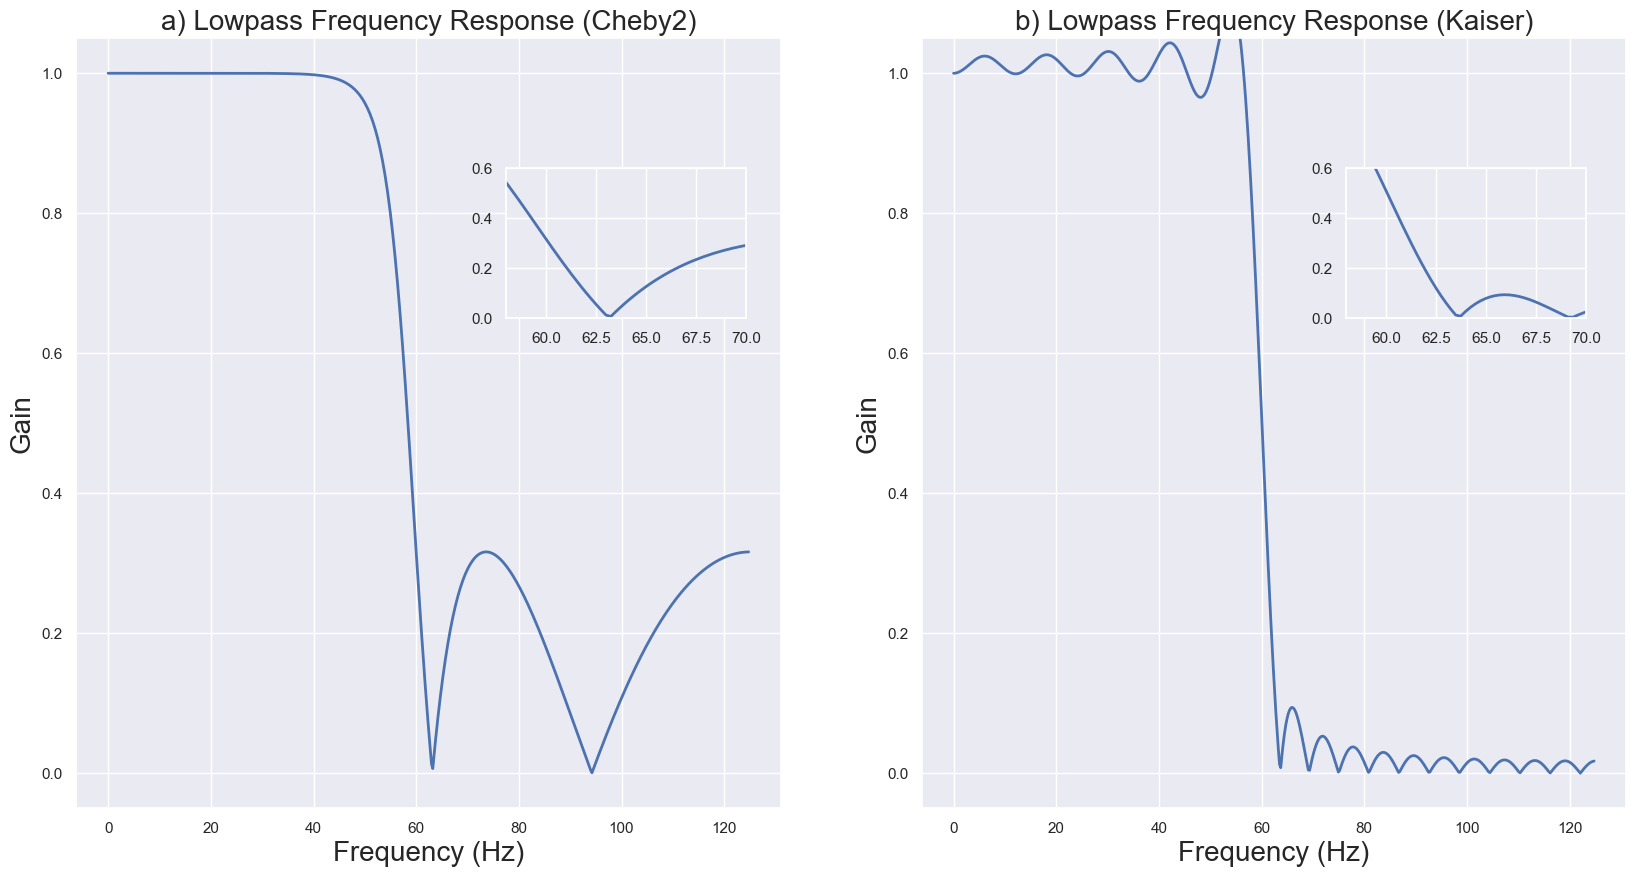

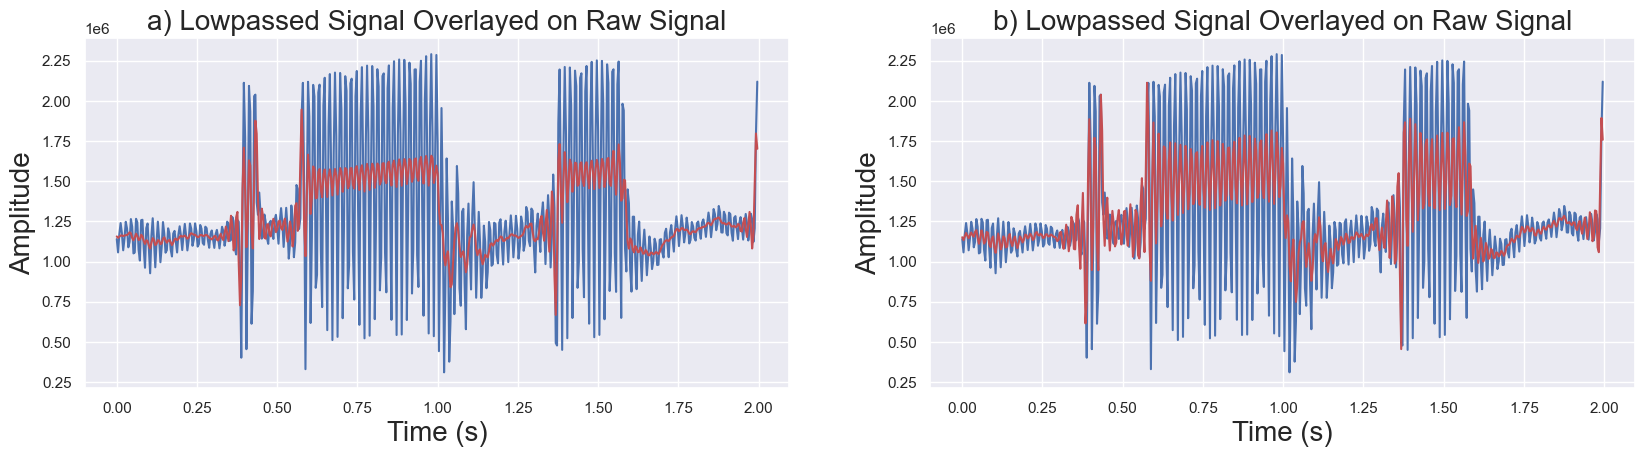

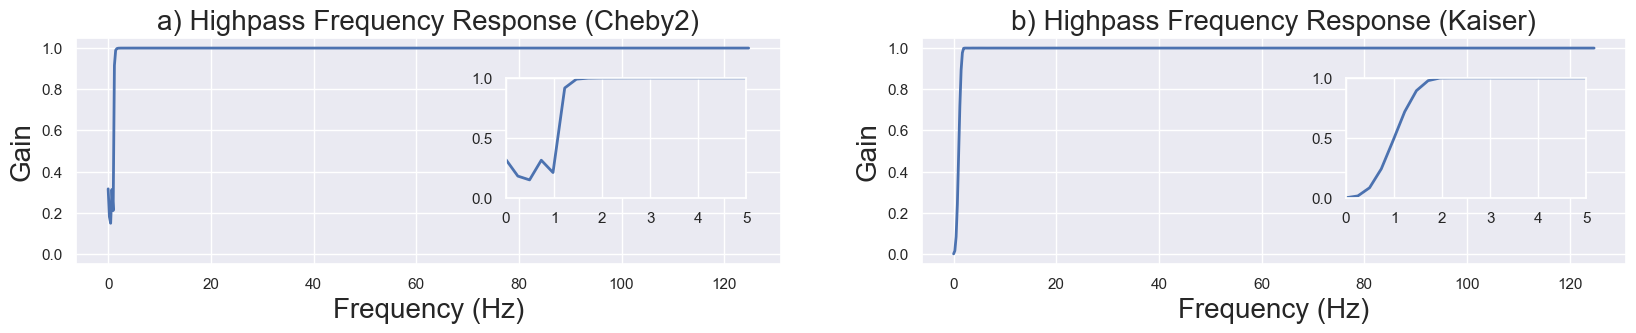

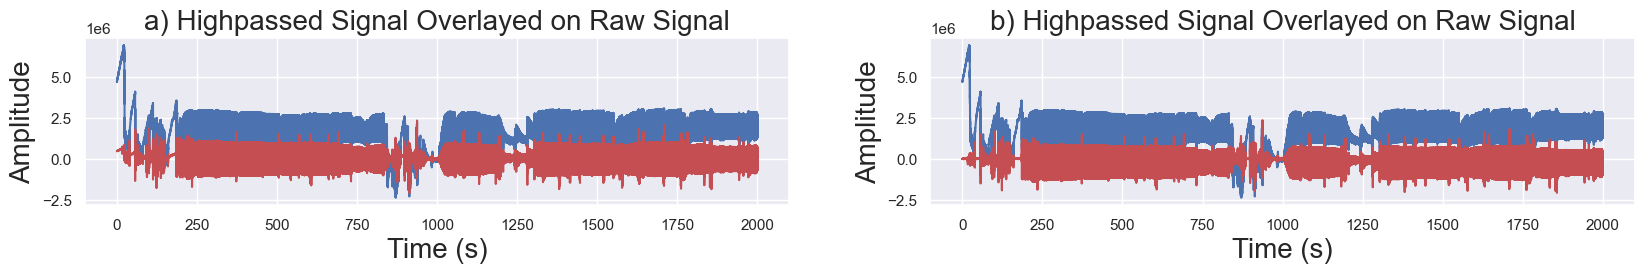

In [43]:
x = subject_outputs[0][["CH1", "CH2", "CH3"]].values.T
fs = 250
n_samples = x.shape[1]
nyq = fs/2.0

#Cutoff Frequencies
high_cut = 1.0/nyq
low_cut = 60/nyq
notch_cut1 = 50 #normalized inside scipy function
notch_cut2 = 100

#Let"s try two different filters: Cheby2 and Kaiser for hp and lp
#Cheby2
#Highpass Filter (Cheby)
b_ch, a_ch = cheby2(4, 10, high_cut, btype = "high", output = "ba")
w_ch, h_ch = freqz(b_ch, a_ch, worN=512)
#Lowpass Filter (Cheby)
b_cl, a_cl = cheby2(4, 10, low_cut, btype = "low", output = "ba")
w_cl, h_cl = freqz(b_cl, a_cl, worN=512)

#Kaiser
#Highpass and Lowpass Filter 
#Width of transition from pass to stop relative to Nyquist.
width_low = 5.0/nyq #15 Hz transition rate
width_high = 2.0/nyq
#Desired attenuation in the stop band, in dB.
ripple_db_low = 20.0
ripple_db_high = 72.0
#Compute the order and Kaiser parameter for the FIR filter.
N_low, beta_low = kaiserord(ripple_db_low, width_low)
N_high, beta_high = kaiserord(ripple_db_high, width_high)
#Use firwin with a Kaiser window to create a lowpass and highpass FIR filter.
taps_low = firwin(N_low, low_cut,window=("kaiser", beta_low)) #Kaiser: window=("kaiser", beta_low) or ("chebwin", 0.0002)
taps_high = firwin(N_high, high_cut, window=("kaiser", beta_high), pass_zero=False) 
w_h, h_h = freqz(taps_high, worN=512)
w_l, h_l = freqz(taps_low, worN=512)


#Plotting: Lowpass
#Filter Frequency Responses
#Lowpass Cheby2
figure(1, figsize=(20,10))
clf()
grid(True)
subplot(1,2,1)
plot((w_cl/np.pi)*nyq, np.absolute(h_cl), linewidth=2)
xlabel("Frequency (Hz)", fontsize = 20)
ylabel("Gain", fontsize = 20)
title("a) Lowpass Frequency Response (Cheby2)", fontsize = 20)
ylim(-0.05, 1.05)

# Upper inset plot.
ax1 = axes([0.34, 0.6, 0.12, 0.15])
plot((w_cl/np.pi)*nyq, np.absolute(h_cl), linewidth=2)
xlim(58,70)
ylim(0.0, 0.6)


#Lowpass Kaiser
subplot(1,2,2)
plot((w_l/np.pi)*nyq, np.absolute(h_l), linewidth=2)
xlabel("Frequency (Hz)", fontsize = 20)
ylabel("Gain", fontsize = 20)
title("b) Lowpass Frequency Response (Kaiser)", fontsize = 20)
ylim(-0.05, 1.05)

#Upper inset plot.
ax2 = axes([0.76, 0.6, 0.12, 0.15])
plot((w_l/np.pi)*nyq, np.absolute(h_l), linewidth=2)
xlim(58,70)
ylim(0.0, 0.6)


#Filters in Time Domain
#Cheby2
start = 50000
figure(2, figsize=(20,10))
subplot(2,2,1)
#x = x[:, :5000]
t = np.arange(0,500,1)/fs
plot(t,x[0,start:start+500])
filtered_x = filtfilt(b_cl, a_cl, x) #apply lp
plot(t, filtered_x[0,start:start+500], "r-")
xlabel("Time (s)", fontsize = 20)
ylabel("Amplitude", fontsize = 20)
title("a) Lowpassed Signal Overlayed on Raw Signal", fontsize = 20)

#Kaiser
subplot(2,2,2)
plot(t,x[0,start:start+500])
filtered_x = filtfilt(taps_low, 1.0, x) #apply lp
plot(t, filtered_x[0,start:start+500], "r-")
xlabel("Time (s)", fontsize = 20)
ylabel("Amplitude", fontsize = 20)
title("b) Lowpassed Signal Overlayed on Raw Signal", fontsize = 20)



#Plotting: Highpass
#Filter Frequency Responses
#Highpass Cheby2
figure(3, figsize=(20,10))
clf()
grid(True)
subplot(3,2,1)
plot((w_ch/np.pi)*nyq, np.absolute(h_ch), linewidth=2)
xlabel("Frequency (Hz)", fontsize = 20)
ylabel("Gain", fontsize = 20)
title("a) Highpass Frequency Response (Cheby2)", fontsize = 20)
ylim(-0.05, 1.05)

# Upper inset plot.
ax1 = axes([0.34, 0.72, 0.12, 0.12])
plot((w_ch/np.pi)*nyq, np.absolute(h_ch), linewidth=2)
xlim(0,5)
ylim(0.0, 1.001)


#Highpass Kaiser
subplot(3,2,2)
plot((w_h/np.pi)*nyq, np.absolute(h_h), linewidth=2)
xlabel("Frequency (Hz)", fontsize = 20)
ylabel("Gain", fontsize = 20)
title("b) Highpass Frequency Response (Kaiser)", fontsize = 20)
ylim(-0.05, 1.05)

#Upper inset plot.
ax2 = axes([0.76, 0.72, 0.12, 0.12])
plot((w_h/np.pi)*nyq, np.absolute(h_h), linewidth=2)
xlim(0,5)
ylim(0.0, 1.001)


#Filters in Time Domain
#Cheby2
figure(4, figsize=(20,10))
subplot(4,2,1)
#x = subject_outputs[0][["CH1", "CH2", "CH3"]].values.T[:, :500000]
t = np.arange(0,500000,1)/fs
plot(t,x[0,:500000])
filtered_x = filtfilt(b_ch, a_ch, x) #apply lp
plot(t, filtered_x[0,:500000], "r-")
xlabel("Time (s)", fontsize = 20)
ylabel("Amplitude", fontsize = 20)
title("a) Highpassed Signal Overlayed on Raw Signal", fontsize = 20)

#Kaiser
subplot(4,2,2)
plot(t,x[0,0:500000])
filtered_x = filtfilt(taps_high, 1.0, x) #apply lp
plot(t, filtered_x[0,:500000], "r-")
xlabel("Time (s)", fontsize = 20)
ylabel("Amplitude", fontsize = 20)
title("b) Highpassed Signal Overlayed on Raw Signal", fontsize = 20)

## Show how that looks for our signal 
(and to display that function works)

100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


Text(0.5, 1.0, 'Bandpassed Signal Overlayed on Raw Signal')

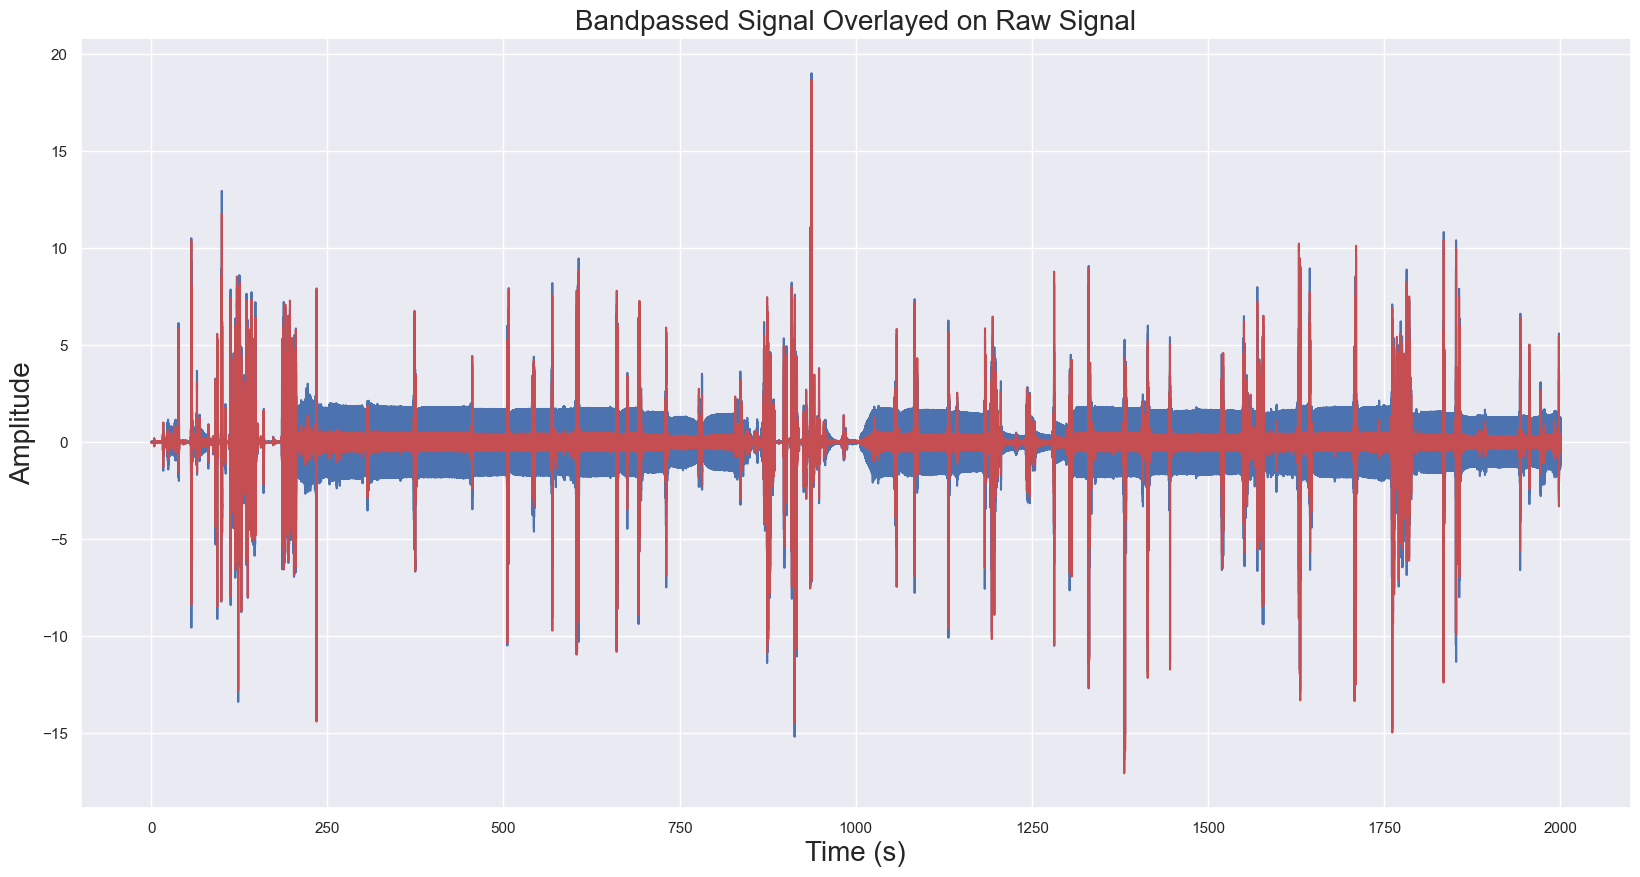

In [35]:
t = np.arange(0,500000,1)/250
data = normalize(subject_outputs)

figure(figsize=(20,10))
#x = subject_outputs[0][["CH1", "CH2", "CH3"]].values.T[:, :500000]
plot(t,data[0][["CH1", "CH2", "CH3"]].values[:500000,0])
#filtered_x = data[0][["CH1", "CH2", "CH3"]].values[:500000,0] #apply lp
data_filtered = kaiser_band_pass_filter(data)
plot(t, data_filtered[0][["CH1", "CH2", "CH3"]].values[:500000,0], "r-")
xlabel("Time (s)", fontsize = 20)
ylabel("Amplitude", fontsize = 20)
title("Bandpassed Signal Overlayed on Raw Signal", fontsize = 20)

## The function that combines the above:
- creates labels
- applies preprocessing
- segments data
- saves data & labels to disk

In [8]:
def create_dataset(data_dir: str, out_dir: str, subjects: List[str], window_size: int = 2, stride: int = 1, fs: int = 250):
    """
    Creates labels, applies preprocessing, segments the data and saves data and labels to disk as .npy files.

    Parameters
    ----------
    data_dir : str
        Path to the directory containing the data.
    out_dir : str
        Path to the directory where the processed data should be saved.
    subjects : List[str]
        List of subjects to be included in the dataset.
    window_size : int
        Size of the window in seconds.
    stride : int
        Stride in seconds.
    fs : int
        Sampling frequency.
    """
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
        
    #Create labels for each subject
    print("Creating labels...")
    data = []
    for subject in tqdm(subjects):
        if not os.path.exists(os.path.join(out_dir, subject)):
            os.makedirs(os.path.join(out_dir, subject))
        if subject in ["sven", "daniel", "david", "khiem", "nader", "zoey", "harry", "michelle","claire"]: 
            time_path = r"C:\Users\s_gue\Desktop\MIT_project\data_karim\{}\blueberry\0timing.pkl".format(subject)
            eeg_path = r"C:\Users\s_gue\Desktop\MIT_project\data_karim\{}\attentivu\exg0.csv".format(subject)
            out = create_labels(time_path, eeg_path)
            data.append(out)

    for dir in os.listdir(out_dir):
        os.makedirs(os.path.join(out_dir, dir, "regular"))
        os.makedirs(os.path.join(out_dir, dir, "random"))

    print("Preprocessing data...")
    #Preprocessing
    data = notch_filter(data)
    data = kaiser_band_pass_filter(data)
    data = normalize(data)
    
    print("Segmenting data...")
    #Save data and labels to disk for each sub-condition.
    window_size = int(window_size * fs)
    stride = int(stride * fs)
    for id, sub in tqdm(enumerate(data)):
        for condition in sub["condition_labels"].unique():
            for condition in sub["condition_labels"].unique():
                if condition.endswith("regular"):
                    con = "regular"
                elif condition.endswith("random"):
                    con = "random"
                else:
                    continue
                
                if not os.path.exists(os.path.join(out_dir, subjects[id], con, condition)):
                    os.makedirs(os.path.join(out_dir, subjects[id], con, condition))

                sub_data_math = sub[["CH1", "CH2", "CH3"]][(sub["condition_labels"] == condition) & (sub["labels"] == "math")].values
                sub_data_rest = sub[["CH1", "CH2", "CH3"]][(sub["condition_labels"] == condition) & (sub["labels"] == "rest")].values
                n_windows_math = (sub_data_math.shape[0] - window_size) // stride + 1
                n_windows_rest = (sub_data_rest.shape[0] - window_size) // stride + 1
                labels_math = sub["labels"][(sub["condition_labels"] == condition) & (sub["labels"] == "math")].values[:n_windows_math]
                labels_rest = sub["labels"][(sub["condition_labels"] == condition) & (sub["labels"] == "rest")].values[:n_windows_rest]
                new_shape_math = (n_windows_math, window_size) + sub_data_math.shape[1:]
                new_strides_math = (stride * sub_data_math.strides[0],) + sub_data_math.strides
                windowed_math = np.lib.stride_tricks.as_strided(sub_data_math, shape=new_shape_math, strides=new_strides_math)
                new_shape_rest = (n_windows_rest, window_size) + sub_data_rest.shape[1:]
                new_strides_rest = (stride * sub_data_rest.strides[0],) + sub_data_rest.strides
                windowed_rest = np.lib.stride_tricks.as_strided(sub_data_rest, shape=new_shape_rest, strides=new_strides_rest)
                X = np.concatenate((windowed_math, windowed_rest), axis=0)
                Y = np.concatenate((labels_math, labels_rest), axis=0)
                np.save(os.path.join(out_dir, subjects[id], con, condition, "X.npy"), X)
                np.save(os.path.join(out_dir, subjects[id], con, condition, "Y.npy"), Y)

In [ ]:
#Something fishy with Claire's timepoints
data_dir = r"C:\Users\s_gue\Desktop\MIT_project\data_karim"
subject = "claire"
time_path = r"C:\Users\s_gue\Desktop\MIT_project\data_karim\{}\blueberry\0timing.pkl".format(subject)
timepoints = pd.read_pickle(time_path)
timepoints

In [12]:
data_dir = r"C:\Users\s_gue\Desktop\MIT_project\data_karim"
out_dir = r"C:\Users\s_gue\Desktop\MIT_project\data_karim\processed_2s_claire"
usable_subs = ["daniel", "david", "khiem", "nader", "zoey"]
usable_subs = ["michelle"]
create_dataset(data_dir, out_dir, usable_subs, window_size=2, stride=1, fs=250)

Creating labels...


  0%|          | 0/1 [00:00<?, ?it/s]C:\Users\s_gue\AppData\Local\Temp\ipykernel_31892\1325198438.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  out_data["timestamps"] = [datetime.strptime(ts, format).timestamp() for ts in eeg_data.UTC_TIME.values]
100%|██████████| 1/1 [03:59<00:00, 239.22s/it]


Preprocessing data...


100%|██████████| 1/1 [00:00<00:00,  5.35it/s]


Segmenting data...


1it [00:40, 40.76s/it]


In [111]:
#Save data and labels to disk for each sub-condition.
out_dir = r"C:\Users\s_gue\Desktop\MIT_project\data_karim\processed"
data = [subject_outputs[0]]
subjects = ["daniel"]
fs = 250
window_size = int(2 * fs)
stride = int(2 * fs)
#Save data and labels to disk for each sub-condition.
for id, sub in enumerate(data):
    for condition in sub["condition_labels"].unique():
        if condition.endswith("regular"):
            con = "regular"
        elif condition.endswith("random"):
            con = "random"
        else:
            continue
        
        if not os.path.exists(os.path.join(out_dir, subjects[id], con, condition)):
            os.makedirs(os.path.join(out_dir, subjects[id], con, condition))

        sub_data_math = sub[["CH1", "CH2", "CH3"]][(sub["condition_labels"] == condition) & (sub["labels"] == "math")].values
        sub_data_rest = sub[["CH1", "CH2", "CH3"]][(sub["condition_labels"] == condition) & (sub["labels"] == "rest")].values
        n_windows_math = (sub_data_math.shape[0] - window_size) // stride + 1
        n_windows_rest = (sub_data_rest.shape[0] - window_size) // stride + 1
        labels_math = sub["labels"][(sub["condition_labels"] == condition) & (sub["labels"] == "math")].values[:n_windows_math]
        labels_rest = sub["labels"][(sub["condition_labels"] == condition) & (sub["labels"] == "rest")].values[:n_windows_rest]
        
        new_shape_math = (n_windows_math, window_size) + sub_data_math.shape[1:]
        new_strides_math = (stride * sub_data_math.strides[0],) + sub_data_math.strides
        windowed_math = np.lib.stride_tricks.as_strided(sub_data_math, shape=new_shape_math, strides=new_strides_math)
        new_shape_rest = (n_windows_rest, window_size) + sub_data_rest.shape[1:]
        new_strides_rest = (stride * sub_data_rest.strides[0],) + sub_data_rest.strides
        windowed_rest = np.lib.stride_tricks.as_strided(sub_data_rest, shape=new_shape_rest, strides=new_strides_rest)
        X = np.concatenate((windowed_math, windowed_rest), axis=0)
        Y = np.concatenate((labels_math, labels_rest), axis=0)
        np.save(os.path.join(out_dir, subjects[id], con, condition, "X.npy"), X)
        np.save(os.path.join(out_dir, subjects[id], con, condition, "Y.npy"), Y)

## Create dataset class for Pytorch

### Datasetclass for models over subjects

In [3]:
class eeg_dataset():

    def __init__(self, path, subjects, condition):
        assert condition in ["visual_regular", "auditory_regular", "mental_regular", "visual_random", "auditory_random", "mental_random"], "Invalid condition."
        self.path = path
        self.subjects = subjects
        self.condition = condition
        self.type = "regular" if condition.endswith("regular") else "random"
        self.X = []
        self.Y = []

        #Load samples (n_samples, window_size, n_channels) and labels (n_samples)
        for subject in self.subjects:
            data_path = os.path.join(self.path, subject, self.type, self.condition)
            self.X.append(np.load(os.path.join(data_path, "X.npy"), allow_pickle=True))
            self.Y.append(np.load(os.path.join(data_path, "Y.npy"), allow_pickle=True))
        self.X = torch.from_numpy(np.concatenate(self.X, axis=0).swapaxes(1,2)).type(torch.DoubleTensor)
        self.Y = np.concatenate(self.Y, axis=0)

        #Create one-hot encoding for labels
        unique, inverse = np.unique(self.Y, return_inverse=True)
        onehot = np.eye(unique.shape[0])[inverse].astype(np.float32)
        self.Y = torch.from_numpy(onehot)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx: int):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (eeg_data, target) where target is index of the target class.
        """
        #sample = np.load(os.path.join(self.path, self.sample_list[idx]))
        # mean = np.mean(sample)
        # std = np.std(sample)
        # sample = (sample-mean)/std
        return self.X[idx,:,:], self.Y[idx] #nn.functional.one_hot(self.target_list[idx].to(torch.int64), num_classes = 2).float()

path = "C:/Users/s_gue/Desktop/MIT_project/data_karim/processed_5s"
subjects_train = ["zoey", "david", "daniel", "nader"]
subjects_val = ["khiem"]
condition = "visual_regular"
train_set = eeg_dataset(path, subjects_train, condition)
val_set = eeg_dataset(path, subjects_val, condition)

### Datasetclass for subject-wise models

In [13]:
def split_data(data_path, label_path):
    data = np.load(data_path, allow_pickle=True)
    labels = np.load(label_path, allow_pickle=True)

    # Calculate the index where "math" ends and "rest" begins
    midpoint = np.where(labels == "rest")[0][0]
    
    # Split the "math" and "rest" data and labels
    math_data = data[:midpoint]
    rest_data = data[midpoint:]
    math_labels = labels[:midpoint]
    rest_labels = labels[midpoint:]

    #Undersample to avoid imbalanced dataset
    if len(rest_labels) > midpoint:
        rest_data = rest_data[:midpoint]
        rest_labels = rest_labels[:midpoint]
    
    # Calculate the split indices for train and validation sets (65/20/15)
    train_split_index = int(0.65 * len(math_data))
    val_split_index = int(0.85 * len(math_data))
    
    X_math_train, X_math_val, X_math_test = np.split(math_data, [train_split_index, val_split_index])
    X_rest_train, X_rest_val, X_rest_test = np.split(rest_data, [train_split_index, val_split_index])
    y_math_train, y_math_val, y_math_test = np.split(math_labels, [train_split_index, val_split_index])
    y_rest_train, y_rest_val, y_rest_test = np.split(rest_labels, [train_split_index, val_split_index])

    # # Split the "math" data and labels into train and validation sets
    # math_train_data = math_data[:train_split_index]
    # math_train_labels = math_labels[:train_split_index]
    # math_validation_data = math_data[train_split_index:]
    # math_validation_labels = math_labels[train_split_index:]
    
    # # Split the "rest" data and labels into train and validation sets
    # rest_train_data = rest_data[:train_split_index]
    # rest_train_labels = rest_labels[:train_split_index]
    # rest_validation_data = rest_data[train_split_index:]
    # rest_validation_labels = rest_labels[train_split_index:]
    
    # Combine the "math" and "rest" train data and validation data
    train_data = np.concatenate((X_math_train, X_rest_train))
    train_labels = np.concatenate((y_math_train, y_rest_train))
    validation_data = np.concatenate((X_math_val, X_rest_val))
    validation_labels = np.concatenate((y_math_val, y_rest_val))
    test_data = np.concatenate((X_math_test, X_rest_test))
    test_labels = np.concatenate((y_math_test, y_rest_test))
    
    return train_data, train_labels, validation_data, validation_labels, test_data, test_labels


class eeg_dataset():

    def __init__(self, data, labels):
        self.X = torch.from_numpy(data.swapaxes(1,2)).type(torch.DoubleTensor)
        self.Y = labels

        #Create one-hot encoding for labels
        unique, inverse = np.unique(self.Y, return_inverse=True)
        onehot = np.eye(unique.shape[0])[inverse].astype(np.float32)
        self.Y = torch.from_numpy(onehot)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx: int):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (eeg_data, target) where target is index of the target class.
        """
        #sample = np.load(os.path.join(self.path, self.sample_list[idx]))
        # mean = np.mean(sample)
        # std = np.std(sample)
        # sample = (sample-mean)/std
        return self.X[idx,:,:], self.Y[idx] #nn.functional.one_hot(self.target_list[idx].to(torch.int64), num_classes = 2).float()

data_path = "C:/Users/s_gue/Desktop/MIT_project/data_karim/processed_2s/daniel/random/visual_random/X.npy"
label_path = "C:/Users/s_gue/Desktop/MIT_project/data_karim/processed_2s/daniel/random/visual_random/Y.npy"
train_data, train_labels, validation_data, validation_labels, test_data, test_labels = split_data(data_path, label_path)
train_set = eeg_dataset(data = train_data, labels = train_labels)
val_set = eeg_dataset(data = validation_data, labels = validation_labels)
test_set = eeg_dataset(data = test_data, labels = test_labels)

## ConvNet model

In [14]:
#torch.set_float32_matmul_precision("medium")
class ConvNet(pl.LightningModule):
    def __init__(self, config: dict):
        super().__init__()
        self.config = config
        #self.save_hyperparameters()
        self.channels = 3
        self.stepsize = None #for cycling lr scheduler
        #self.class_weights = class_weights #torch.from_numpy(train_set.__len__() / (2 * np.bincount(train_set.targets)))
        self.loss = nn.CrossEntropyLoss() 
        self.acc = Accuracy(task = "binary", num_classes = 2)

        chan_out = self.config["chan_out"]
        pool_out = self.config["pool_out"]
        self.blocks = dict()

        for n in range(self.config["n_blocks"]):
            self.blocks[f"block_{n}"] = nn.Sequential(
                nn.Conv1d(in_channels=self.channels,
                        out_channels=chan_out,
                        kernel_size=self.config["kernel_size"],
                        padding="same",
                        ),
                nn.LazyBatchNorm1d(),
                nn.GELU(),
                nn.AdaptiveMaxPool1d(output_size = pool_out),
                nn.Dropout(p=self.config["dropout"]),
            )
            self.channels = chan_out
            chan_out = chan_out//2
            pool_out = pool_out//2

        self.conv_net = nn.Sequential(*[
            block for block in self.blocks.values()
        ])
        self.classifier_head = nn.Sequential(*[
            nn.Flatten(),
            nn.LazyLinear(out_features = 2), 
            nn.GELU()
            ])
        
    def forward(self, x):
        x = self.conv_net(x)
        x = self.classifier_head(x)
        return x

    def configure_optimizers(self):
        optimizer = optim.Adam(params = self.parameters(), lr = self.config["lr"], weight_decay = self.config["weight_decay"]) 
        #parameters for the cycling lr scheduler are chosen according to Smith (2015): https://arxiv.org/pdf/1506.01186.pdf
        # lr = torch.optim.lr_scheduler.CyclicLR(
        #     optimizer, base_lr = self.config["lr"],
        #     max_lr = 4*self.config["lr"],
        #     step_size_up = 4*int(self.stepsize),
        #     mode = "triangular",
        #     cycle_momentum = False
        #     )
        
        #If using Cyclic LR:
        #Fix pickling bug for cycling learning rate (https://github.com/pytorch/pytorch/issues/88684)
        #instantiate the WeakMethod in the lr scheduler object into the custom scale function attribute
        # lr._scale_fn_custom = lr._scale_fn_ref()
        # #remove the reference so there are no more WeakMethod references in the object
        # lr._scale_fn_ref = None

        lr = torch.optim.lr_scheduler.OneCycleLR(
            optimizer = optimizer,
            max_lr = self.config["lr"],
            epochs = self.config["epochs"],
            steps_per_epoch = self.trainer.estimated_stepping_batches // self.config["epochs"],
            cycle_momentum = True
            )
        
        lr_scheduler = {
            "scheduler": lr,
            "interval": "step",
            "name": "Learning Rate Scheduling"
        }
        return [optimizer], [lr_scheduler]

    def training_step(self, batch, batch_idx):
        x,y = batch
        logit = self.forward(x.float()) 
        train_loss = self.loss(logit, y)
        _, y_pred = torch.max(logit, dim = 1)
        _, y_true = torch.max(y, dim = 1)
        self.log("train_loss", train_loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("train_acc", self.acc(y_pred, y_true), on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return train_loss
        
    def validation_step(self, batch, batch_idx):
        x,y = batch
        logit = self.forward(x.float())
        val_loss = self.loss(logit, y)
        _, y_pred = torch.max(logit, dim = 1)
        _, y_true = torch.max(y, dim = 1)
        self.log("val_loss", val_loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_acc", self.acc(y_pred, y_true), on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return val_loss
    
    def test_step(self, batch, batch_idx):
        x,y = batch
        print("TEST")
        logit = self.forward(x.float())
        test_loss = self.loss(logit, y)
        _, y_pred = torch.max(logit, dim = 1)
        _, y_true = torch.max(y, dim = 1)
        self.log("test_loss", test_loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("test_acc", self.acc(y_pred, y_true), on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return test_loss

In [ ]:
# os.environ["WANDB__SERVICE_WAIT"] = "300"
# wandb.finish()

#For running wandb offline:
#os.environ["WANDB_MODE"] = "offline"

#To push metrics to wandb cloud afterwards
#wandb sync YOUR_RUN_DIRECTORY

## Run sweeps for hyperparameter tuning
This does 30 runs of 100 epochs trying different hyperparameter combinations for each combination of subject + condition.

In [ ]:
for subject in ["sven"]: #"zoey","nader", "david", "daniel", "khiem", "michelle"
    for type in ["random"]: #"regular", 
        for condition in [ "mental_"]: #"visual_", "auditory_",
            con = condition + type
            data_path = "C:/Users/s_gue/Desktop/MIT_project/data_karim/processed_2s/{}/{}/{}/X.npy".format(subject, type, con)
            label_path = "C:/Users/s_gue/Desktop/MIT_project/data_karim/processed_2s/{}/{}/{}/Y.npy".format(subject, type, con)
            train_data, train_labels, validation_data, validation_labels, test_data, test_labels = split_data(data_path, label_path)
            train_set = eeg_dataset(data = train_data, labels = train_labels)
            val_set = eeg_dataset(data = validation_data, labels = validation_labels)
            test_set = eeg_dataset(data = test_data, labels = test_labels)

            def train(config, train_set, val_set, test_set):
                # Initialize a new wandb run
                #with wandb.init(config = config) as run:
                wandb.init(config=config)
                config = wandb.config
                # Init model
                model = ConvNet(config = config)
                # Create a ModelCheckpoint callback
                checkpoint_callback = ModelCheckpoint(
                    monitor="val_acc",
                    mode="max",
                    filename="best-model-{epoch:02d}-{val_acc:.2f}",
                    save_top_k=1,
                    save_weights_only=True,
                    verbose=True,
                )
                lr_monitor = LearningRateMonitor(logging_interval="epoch")

                # Initialize a trainer
                trainer = pl.Trainer(
                    max_epochs = config["epochs"],
                    logger = pl.loggers.WandbLogger(save_dir="logs/"),
                    callbacks = [checkpoint_callback, lr_monitor], #pl.callbacks.EarlyStopping(monitor="val_acc")
                )
                train_loader = torch.utils.data.DataLoader(train_set, batch_size = config["batch_size"],
                                                shuffle = True, drop_last = True)
                
                val_loader = torch.utils.data.DataLoader(val_set, batch_size = config["batch_size"],
                                                shuffle = False, drop_last = True)

                test_loader = torch.utils.data.DataLoader(test_set, batch_size = config["batch_size"],
                                        shuffle = False, drop_last = False)
                # Train the model 
                model.stepsize = np.around(train_set.__len__()*0.8/config["batch_size"]) 
                trainer.fit(model, train_loader, val_loader)
                trainer.test(dataloaders = test_loader)
                print("AFTER_TEST")
                wandb.run.finish()

            #Define all parameters that should be logged (and/or tuned)        
            sweep_config = {
                "method": "random",
                "name": "sweep",
                'run_cap' : 3,
                "metric": {
                    "goal": "maximize", 
                    "name": "val_acc"
                    },
                "parameters": {
                    "batch_size": {"values": [16, 32, 64]},
                    "epochs": {"value": 100},
                    "lr": {"max": 1e-2, "min": 1e-6},
                    "weight_decay": {"max": 1e-3, "min": 1e-8},
                    "dropout": {"values": [0.2, 0.5, 0.7]},
                    "kernel_size": {"values": [64, 128, 256]},
                    "chan_out": {"values": [8, 16]},
                    "n_blocks": {"value": 1},
                    "pool_out": {"values": [8, 16]},
                    "sample_rate": {"value": 250},
                    "num_classes": {"value": 2},
                }
            }

            train = partial(train, config = None, train_set = train_set, val_set = val_set, test_set = test_set)

            # Initialize a new sweep ()
            sweep_id = wandb.sweep(sweep_config, project="AttentivU_EEG_2_subjectwise_{}_{}_shallow".format(subject, con))

            # Run the sweep
            wandb.agent(sweep_id, function=train)

## Old model (without sweeps)

In [26]:
# #torch.set_float32_matmul_precision("medium")
# class ConvNet(pl.LightningModule):
#     def __init__(
#         self,
#         train_set = train_set,
#         val_set = val_set,
#         batch_size = 32,
#         epochs = 200,
#         lr = 0.000004,
#         weight_decay = 0.01,
#         channels = 3,
#         chan_out = 64,
#         kernel_size = 128,
#         pool_out = 32,
#         n_blocks = 3,
#         dropout = 0.1,
#         sample_rate = 250,
#         num_classes = 2,
#     ):
#         super().__init__()
#         self.save_hyperparameters()
        
#         self.channels = channels
#         self.sample_rate = sample_rate
#         self.dropout = dropout
#         self.kernel_size = kernel_size
#         self.chan_out = chan_out
#         self.pool_out = pool_out
#         self.n_blocks = n_blocks
#         self.epochs = epochs

#         #Hyperparameters
#         self.lr = lr
#         self.weight_decay = weight_decay
#         self.batch_size = batch_size
#         self.train_set = train_set
#         self.val_set = val_set
#         self.stepsize = np.around(self.train_set.__len__()*0.8/self.batch_size) #for cycling lr scheduler
#         #self.class_weights = class_weights #torch.from_numpy(train_set.__len__() / (2 * np.bincount(train_set.targets)))
#         self.loss = nn.CrossEntropyLoss() 
#         self.acc = Accuracy(task = "binary", num_classes = num_classes)

#         #Log Hyperparameters
#         self.save_hyperparameters()

#         self.blocks = dict()
#         for n in range(n_blocks):
#             self.blocks[f"block_{n}"] = nn.Sequential(
#                 nn.Conv1d(in_channels=channels,
#                         out_channels=chan_out,
#                         kernel_size=kernel_size,
#                         padding="same",
#                         ),
#                 nn.LazyBatchNorm1d(),
#                 nn.GELU(),
#                 nn.AdaptiveMaxPool1d(output_size = pool_out),
#                 nn.Dropout(p=dropout),
#             )
#             channels = chan_out
#             chan_out = chan_out//2
#             pool_out = pool_out//2

#         self.conv_net = nn.Sequential(*[
#             block for block in self.blocks.values()
#         ])
#         self.classifier_head = nn.Sequential(*[
#             nn.Flatten(),
#             nn.LazyLinear(out_features = 2), 
#             nn.GELU()
#             ])
        
#     def forward(self, x):
#         x = self.conv_net(x)
#         x = self.classifier_head(x)
#         return x

#     def configure_optimizers(self):
#         optimizer = optim.Adam(params = self.parameters(), lr = self.lr)#, weight_decay = self.weight_decay) 
#         #parameters for the cycling lr scheduler are chosen according to Smith (2015): https://arxiv.org/pdf/1506.01186.pdf
#         lr = torch.optim.lr_scheduler.CyclicLR(
#             optimizer, base_lr = self.lr,
#             max_lr = 4*self.lr,
#             step_size_up = 4*int(self.stepsize),
#             mode = "triangular",
#             cycle_momentum = False
#             )
#         #Fix pickling bug for cycling learning rate (https://github.com/pytorch/pytorch/issues/88684)
#         #instantiate the WeakMethod in the lr scheduler object into the custom scale function attribute
#         lr._scale_fn_custom = lr._scale_fn_ref()
#         #remove the reference so there are no more WeakMethod references in the object
#         lr._scale_fn_ref = None
#         lr_scheduler = {
#             "scheduler": lr,
#             "interval": "step",
#             "name": "Learning Rate Scheduling"
#         }
#         return [optimizer], [lr_scheduler]

#     def training_step(self, batch, batch_idx):
#         x,y = batch
#         logit = self.forward(x.float()) 
#         train_loss = self.loss(logit, y)
#         _, y_pred = torch.max(logit, dim = 1)
#         _, y_true = torch.max(y, dim = 1)
#         self.log("train_loss", train_loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
#         self.log("train_acc", self.acc(y_pred, y_true), on_step=False, on_epoch=True, prog_bar=True, logger=True)
#         return train_loss
        
#     def validation_step(self, batch, batch_idx):
#         x,y = batch
#         logit = self.forward(x.float())
#         val_loss = self.loss(logit, y)
#         _, y_pred = torch.max(logit, dim = 1)
#         _, y_true = torch.max(y, dim = 1)
#         self.log("val_loss", val_loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
#         self.log("val_acc", self.acc(y_pred, y_true), on_step=False, on_epoch=True, prog_bar=True, logger=True)
#         return val_loss

#     def train_dataloader(self):
#         train_loader = torch.utils.data.DataLoader(self.train_set, batch_size = self.batch_size,
#                                            shuffle = True, drop_last = True)
#         return train_loader

#     def val_dataloader(self):
#         val_loader = torch.utils.data.DataLoader(self.val_set, batch_size = self.batch_size,
#                                          shuffle = False, drop_last = True)
#         return val_loader

# model = ConvNet()

c:\Users\s_gue\anaconda3\envs\mindstream\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [ ]:
wandb_logger = WandbLogger(project="AttentivU_EEG", log_model = "all")
checkpoint_callback = ModelCheckpoint(monitor="val_accuracy", mode="max")
lr_monitor = LearningRateMonitor(logging_interval="epoch")
# checkpoint_callback = ModelCheckpoint(
#     dirpath="C:/Users/Daydreamore/Desktop/Semester/BCI/model_checkpoints",
#     monitor="val/acc",
#     save_top_k=2
# )
    
trainer = pl.Trainer(max_epochs = 200, logger = wandb_logger, callbacks = [checkpoint_callback, lr_monitor])

In [ ]:
trainer.fit(model)

## Classical Machine Learning

Tasks:
1. split data into 80% (training and validation for CV) and 20% (test)
2. Calculate psds per sample
3. Nested CV to find optimal model
4. Evaluation on test set.

Data splitting and psds

In [19]:
#We use the preprocessed data from the deep learning paradigm. 
#The directory structure is: data_karim/processed_2s/subject/type/condition/data.npy

#Helper function that splits data such that an exact number of blocks for shuffling can be obtained.
def nearestX(num, x):
    remainder = abs(num % x)
    if remainder == 0:
        return num
    else:
        if remainder < x/2:
            return num - remainder
        else:
            return num + x - remainder
        
#Determine how large blocks for shuffling should be:
blocksize = 14 #Half of sub_condition duration

data_dir = r"C:\Users\s_gue\Desktop\MIT_project\data_karim\processed_2s"
for subject in os.listdir(data_dir):
    for type in os.listdir(os.path.join(data_dir, subject)):
        for condition in os.listdir(os.path.join(data_dir, subject, type)):
            X = np.load(os.path.join(data_dir, subject, type, condition, "X.npy"), allow_pickle=True).swapaxes(1,2)
            Y = np.load(os.path.join(data_dir, subject, type, condition, "Y.npy"), allow_pickle=True)
            X_psd = welch(X, fs=250, nperseg=250, axis=-1)[1][:,:,:60] #up to 60Hz because that is how we filtered

            #Ensure balanced dataset
            length = np.sum(Y == "math")*2
            X_psd = X_psd[:length]
            Y = Y[:length]
            
            #We have an issue, because the data is first half math, second half rest.
            #Therefore, we take the last 20% samples of the first and second half respectively for the test set.
            half = int(Y.shape[0]/2)
            split = int(0.8*half)
            X_psd_test = np.concatenate((X_psd[split:half], X_psd[half+split:]), axis=0)
            Y_test = np.concatenate((Y[split:half], Y[half+split:]), axis=0)
            X_psd_train = np.concatenate((X_psd[:split], X_psd[half:half+split]), axis=0)
            Y_train = np.concatenate((Y[:split], Y[half:half+split]), axis=0)

            #Cutoff few samples from the end to match with blocks if necessary
            num = nearestX(X_psd_train.shape[0], blocksize)
            X_psd_train = X_psd_train[:num]
            Y_train = Y_train[:num]

            #Shuffle training data blockwise because we have overlapping windows
            #Combine data and labels for shuffling
            data_zip = list(zip(X_psd_train, Y_train))

            #Create blocks
            data_blocks = [data_zip[i:i+blocksize] for i in range(0,len(data_zip),blocksize)]

            #Shuffle the blocks
            np.random.shuffle(data_blocks)

            # concatenate the shuffled blocks and unzip
            data_blocks = [b for bs in data_blocks for b in bs]
            X_psd_train, Y_train = list(zip(*data_blocks))

            np.save(os.path.join(data_dir, subject, type, condition, "X_psd_train.npy"), np.array(X_psd_train))
            np.save(os.path.join(data_dir, subject, type, condition, "Y_psd_train.npy"), np.array(Y_train))
            np.save(os.path.join(data_dir, subject, type, condition, "X_psd_test.npy"), X_psd_test)
            np.save(os.path.join(data_dir, subject, type, condition, "Y_psd_test.npy"), Y_test)

Nested CV

In [20]:
data_dir = r"C:\Users\s_gue\Desktop\MIT_project\data_karim\processed_2s"
X_train = np.load(os.path.join(data_dir, "zoey", "random", "visual_random", "X_psd_train.npy"), allow_pickle=True)
Y_train = np.load(os.path.join(data_dir, "zoey", "random", "visual_random", "Y_psd_train.npy"), allow_pickle=True)
X_test = np.load(os.path.join(data_dir, "zoey", "random", "visual_random", "X_psd_test.npy"), allow_pickle=True)
Y_test = np.load(os.path.join(data_dir, "zoey", "random", "visual_random", "Y_psd_test.npy"), allow_pickle=True)
Y_test

array(['math', 'math', 'math', 'math', 'math', 'math', 'math', 'math',
       'math', 'math', 'math', 'math', 'math', 'math', 'math', 'math',
       'math', 'math', 'math', 'math', 'math', 'math', 'math', 'math',
       'math', 'math', 'math', 'math', 'math', 'math', 'math', 'math',
       'math', 'math', 'math', 'math', 'math', 'math', 'math', 'math',
       'math', 'math', 'math', 'math', 'math', 'math', 'math', 'math',
       'math', 'math', 'math', 'math', 'math', 'math', 'math', 'math',
       'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest',
       'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest',
       'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest',
       'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest',
       'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest',
       'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest',
       'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest'],
     

In [13]:
X_train = np.load(os.path.join(data_dir, "zoey", "random", "visual_random", "X_psd_train.npy"), allow_pickle=True).reshape(-1, 3*60)
Y_train = np.load(os.path.join(data_dir, "zoey", "random", "visual_random", "Y_psd_train.npy"), allow_pickle=True)

#Turn y from string classes to 0/1 labels for accuracy calculation
Y_train = (Y_train=='math').astype(int)
outer_results = list()
specificity_results = list()
sensitivity_results = list()
#Outer CV
cv_outer = KFold(n_splits=10, shuffle=False)#random_state=42
for train_ix, val_ix in cv_outer.split(X_train): 
    #split data
    x_train, x_val = X_train[train_ix, :], X_train[val_ix, :]
    y_train, y_val = Y_train[train_ix], Y_train[val_ix]

    #Inner CV
    cv_inner = KFold(n_splits=5, shuffle=False) #, random_state=42)
    model = SVC()
    #define search space
    param_grid = dict()
    param_grid["C"] = np.logspace(-18, 9, num=20, base=2).tolist() 
    param_grid["kernel"] = ["linear", "rbf", "sigmoid"] 
    param_grid["gamma"] = np.logspace(-18, 9, num=20, base=2).tolist() 
    search = GridSearchCV(model, param_grid, scoring="accuracy", cv=cv_inner, refit=True, error_score="raise")
    result = search.fit(x_train, y_train) #runs fit with all sets of parameters
    best_model = result.best_estimator_ #get the best performing model fit on the whole training set
    yhat = best_model.predict(x_val) #evaluate model on the hold out dataset
    acc_svm = accuracy_score(y_val, yhat) #evaluate the model
    outer_results.append(acc_svm) #store result
    print(">Accuracy=%.3f, est=%.3f, cfg=%s" % (acc_svm, result.best_score_, result.best_params_)) #overall acc and best params

    #sensitivity & specificity
    class_acc = np.bincount(y_val[y_val == yhat])
    class_count = np.bincount(y_val)

    for ix, tclass in enumerate(class_acc):
        if ix == 0:
            condition = "specificity"
        else:
            condition = "sensitivity"

        if tclass == 0:
            if ix == 0:
                specificity = 0.0
                specificity_results.append(specificity)
            else:
                sensitivity = 0.0
                sensitivity_results.append(sensitivity)
            print(f">{condition}: {0.0}")
        else:
            if ix == 0:
                specificity = np.around(tclass/class_count[ix], 3)
                specificity_results.append(specificity)
                print(f">{condition}: {specificity}")
            else:
                sensitivity = np.around(tclass/class_count[ix], 3)
                sensitivity_results.append(sensitivity)
                print(f">{condition}: {sensitivity}")

            
#summarize estimated performance of the model
outer_results = np.array(outer_results)
specificity_results = np.array(specificity_results)
sensitivity_results = np.array(sensitivity_results)
print("----------Final Result----------")
print("Accuracy: %.3f (%.3f)" % (np.mean(outer_results), np.std(outer_results)))
print("Specificity: %.3f (%.3f)" % (np.mean(specificity_results), np.std(specificity_results)))
print("Sensitivity: %.3f (%.3f)" % (np.mean(sensitivity_results), np.std(sensitivity_results)))

>Accuracy=0.644, est=0.750, cfg={'C': 71.40210673673884, 'gamma': 512.0, 'kernel': 'rbf'}
>specificity: 0.941
>sensitivity: 0.464
>Accuracy=0.822, est=0.738, cfg={'C': 191.201147091774, 'gamma': 512.0, 'kernel': 'rbf'}
>specificity: 0.795
>sensitivity: 1.0
>Accuracy=0.867, est=0.708, cfg={'C': 512.0, 'gamma': 512.0, 'kernel': 'rbf'}
>specificity: 0.444
>sensitivity: 0.972
>Accuracy=0.556, est=0.768, cfg={'C': 512.0, 'gamma': 512.0, 'kernel': 'rbf'}
>specificity: 0.235
>sensitivity: 0.75
>Accuracy=0.800, est=0.685, cfg={'C': 512.0, 'gamma': 512.0, 'kernel': 'rbf'}
>specificity: 0.9
>sensitivity: 0.6
>Accuracy=0.978, est=0.648, cfg={'C': 512.0, 'gamma': 512.0, 'kernel': 'rbf'}
>specificity: 0.947
>sensitivity: 1.0
>Accuracy=0.455, est=0.729, cfg={'C': 512.0, 'gamma': 512.0, 'kernel': 'rbf'}
>specificity: 0.5
>sensitivity: 0.441
>Accuracy=0.705, est=0.699, cfg={'C': 191.201147091774, 'gamma': 512.0, 'kernel': 'rbf'}
>specificity: 0.861
>Accuracy=0.614, est=0.694, cfg={'C': 512.0, 'gamma':

Testing

In [30]:
np.unique(Y_test, return_counts=True)

(array([0, 1]), array([56, 56], dtype=int64))

In [20]:
data_dir = r"C:\Users\s_gue\Desktop\MIT_project\data_karim\processed_2s"
for subject in os.listdir(data_dir):
    for con in os.listdir(os.path.join(data_dir, subject)):
        for condition in os.listdir(os.path.join(data_dir, subject, con)):
            X_train = np.load(os.path.join(data_dir, subject, con, condition, "X_psd_train.npy"), allow_pickle=True).reshape(-1, 3*60)
            Y_train = np.load(os.path.join(data_dir, subject, con, condition, "Y_psd_train.npy"), allow_pickle=True)
            X_test = np.load(os.path.join(data_dir, subject, con, condition, "X_psd_test.npy"), allow_pickle=True).reshape(-1, 3*60)
            Y_test = np.load(os.path.join(data_dir, subject, con, condition, "Y_psd_test.npy"), allow_pickle=True)
            Y_train = (Y_train=='math').astype(int)
            Y_test = (Y_test=='math').astype(int)

            model = SVC(C = 512.0, kernel = "rbf", gamma = 3.71) # )
            #model = SVC(C = 191.2, kernel = "rbf", gamma = 9.95)
            model.fit(X_train, Y_train)
            yhat = model.predict(X_test)
            acc_svm = accuracy_score(Y_test, yhat)
            print(f"Subject: {subject}, Condition: {condition}, Accuracy: {acc_svm}")

Subject: daniel, Condition: auditory_random, Accuracy: 0.45535714285714285
Subject: daniel, Condition: mental_random, Accuracy: 0.48214285714285715
Subject: daniel, Condition: visual_random, Accuracy: 0.6607142857142857
Subject: daniel, Condition: auditory_regular, Accuracy: 0.5132743362831859
Subject: daniel, Condition: mental_regular, Accuracy: 0.35398230088495575
Subject: daniel, Condition: visual_regular, Accuracy: 0.7079646017699115
Subject: david, Condition: auditory_random, Accuracy: 0.5446428571428571
Subject: david, Condition: mental_random, Accuracy: 0.2857142857142857
Subject: david, Condition: visual_random, Accuracy: 0.5178571428571429
Subject: david, Condition: auditory_regular, Accuracy: 0.5309734513274337
Subject: david, Condition: mental_regular, Accuracy: 0.5221238938053098
Subject: david, Condition: visual_regular, Accuracy: 0.5132743362831859
Subject: khiem, Condition: auditory_random, Accuracy: 0.625
Subject: khiem, Condition: mental_random, Accuracy: 0.55357142857